<a href="https://colab.research.google.com/github/Czyundream/Leetcodetest/blob/main/%E6%9D%8E%E6%B2%90%E2%80%94%E7%BA%BF%E5%BD%A2%E5%9B%9E%E5%BD%92%E9%83%A8%E5%88%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-99e8wkwi
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-99e8wkwi
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80414 sha256=7afb08e228ab86cb82454e83134fa9b1f7ce67eebaa7b70664609ea0a854a9d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8aabj70/wheels/73/f4/42/d2b85ca46d85a241d6aa57c1c24027de2d2258202bb67945f9
Successfully built d2l


In [2]:
#线形回归从零开始实现
import torch
%matplotlib inline
import random
from d2l import torch as d2l

##生成人造数据集
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。 我们将使用低维数据，这样可以很容易地将其可视化。 在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。 我们的合成数据集是一个矩阵$𝐗∈\mathbb{R}^{1000×2}$。
使用参数：$\mathbf{w}=[2,-3.4]^{T},b=4.2$和噪声项$\epsilon $生成数据集和标签：  
<center>$\mathbf{y}=\mathbf{X}\mathbf{w}+b+ϵ$

In [3]:
def synthetic_data(w, b, num_examples):
    '''生成y = Xw + b + 噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y +=torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1,1))

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

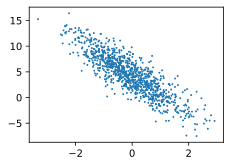

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

##读取数据集
---
在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #进行打乱操作
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]#执行分批操作
        )
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

#执行读取第一个小批量打印，每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。
for X, y in data_iter(batch_size, features, labels):
    print(X,'\n', y)
    break

tensor([[ 0.0215, -0.9477],
        [ 0.2233,  0.0338],
        [-0.1053,  0.3040],
        [-0.1844,  0.9636],
        [-0.3288, -0.7341],
        [-0.1410, -1.1926],
        [ 0.9772,  0.1854],
        [-0.1242, -0.4478],
        [-0.4434, -0.5831],
        [-1.2805, -0.2719]]) 
 tensor([[7.4675],
        [4.5333],
        [2.9532],
        [0.5548],
        [6.0238],
        [7.9860],
        [5.5121],
        [5.4733],
        [5.2966],
        [2.5734]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

##初始化模型参数

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。

##定义模型

接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。 回想一下，要计算线性模型的输出， 我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。注意，上面$\mathbf{X}$$\mathbf{w}$是一个向量，而$b$是一个标量。  
广播机制：当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [9]:
def linreg(X, w, b):
    '''线性回归模型'''
    return torch.matmul(X, w) + b

##定义损失函数
---
因为需要计算损失函数的梯度，所以我们应该先定义损失函数。 这里平方损失函数。在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [10]:
def squared_loss(y_hat, y):
    '''均方误差'''
    return (y_hat - y.reshape(y_hat.shape))**2 / 2 #并没有求均值

##定义优化算法
---
实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [11]:
def sgd(params, lr, batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size #在这一步进行了求均值
            param.grad.zero_()

##训练过程
---
 理解这段代码至关重要，因为从事深度学习后， 你会一遍又一遍地看到几乎相同的训练过程。 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。 

In [12]:
lr = 0.03#学习率不能太小，也不能太大
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):#第一层实现对所有数据扫一遍
    for X, y in data_iter(batch_size, features, labels):#每一次拿出一个批量大小的X，y 
        l = loss(net(X, w, b), y)#y预测和y的小批量损失
        #此时l形状是（'batch_size'，1），不是一个标量。l中所有元素被加到一起，并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)#使用参数的梯度更新参数
    with torch.no_grad():#对数据jingjing
        train_l = loss(net(features, w , b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028450
epoch 2, loss 0.000096
epoch 3, loss 0.000051


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。

In [13]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差：tensor([0.0009, 0.0004], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0005], grad_fn=<RsubBackward1>)


学习率不能太小也不能太大
举例：

In [14]:
#每次需要重新随机初始化，避免跟着上一次的梯度结果
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.001#学习率不能太小，也不能太大
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):#第一层实现对所有数据扫一遍
    for X, y in data_iter(batch_size, features, labels):#每一次拿出一个批量大小的X，y 
        l = loss(net(X, w, b), y)#y预测和y的小批量损失
        #此时l形状是（'batch_size'，1），不是一个标量。l中所有元素被加到一起，并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)#使用参数的梯度更新参数
    with torch.no_grad():#对数据jingjing
        train_l = loss(net(features, w , b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 14.134047
epoch 2, loss 11.451359
epoch 3, loss 9.278143
epoch 4, loss 7.517622
epoch 5, loss 6.091351
epoch 6, loss 4.935833
epoch 7, loss 3.999631
epoch 8, loss 3.241134
epoch 9, loss 2.626570
epoch 10, loss 2.128618


In [15]:
#每次需要重新随机初始化，避免跟着上一次的梯度结果
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 10#学习率不能太小，也不能太大
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):#第一层实现对所有数据扫一遍
    for X, y in data_iter(batch_size, features, labels):#每一次拿出一个批量大小的X，y 
        l = loss(net(X, w, b), y)#y预测和y的小批量损失
        #此时l形状是（'batch_size'，1），不是一个标量。l中所有元素被加到一起，并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)#使用参数的梯度更新参数
    with torch.no_grad():#对数据jingjing
        train_l = loss(net(features, w , b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss nan
epoch 2, loss nan
epoch 3, loss nan
epoch 4, loss nan
epoch 5, loss nan
epoch 6, loss nan
epoch 7, loss nan
epoch 8, loss nan
epoch 9, loss nan
epoch 10, loss nan
